In [1]:
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import heatmap
from keras.layers import Conv1D, MaxPool1D, BatchNormalization, Bidirectional, LSTM, Flatten, Input, Dense
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report , confusion_matrix
from keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

Loading the train and test dataset

In [2]:
train = 'mitbih_train.csv'
test = 'mitbih_test.csv'
column_names = [i for i in range(187)] + ['Label']
train_df = pd.read_csv(train, header=None, names=column_names)
test_df = pd.read_csv(test, header=None, names=column_names)
print("Information about train data")
print(train_df.info())
print("Information about test data")
print(test_df.info())

Information about train data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to Label
dtypes: float64(188)
memory usage: 125.6 MB
None
Information about test data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to Label
dtypes: float64(188)
memory usage: 31.4 MB
None


PLOTTING SAMPLE FROM EVERY ECG

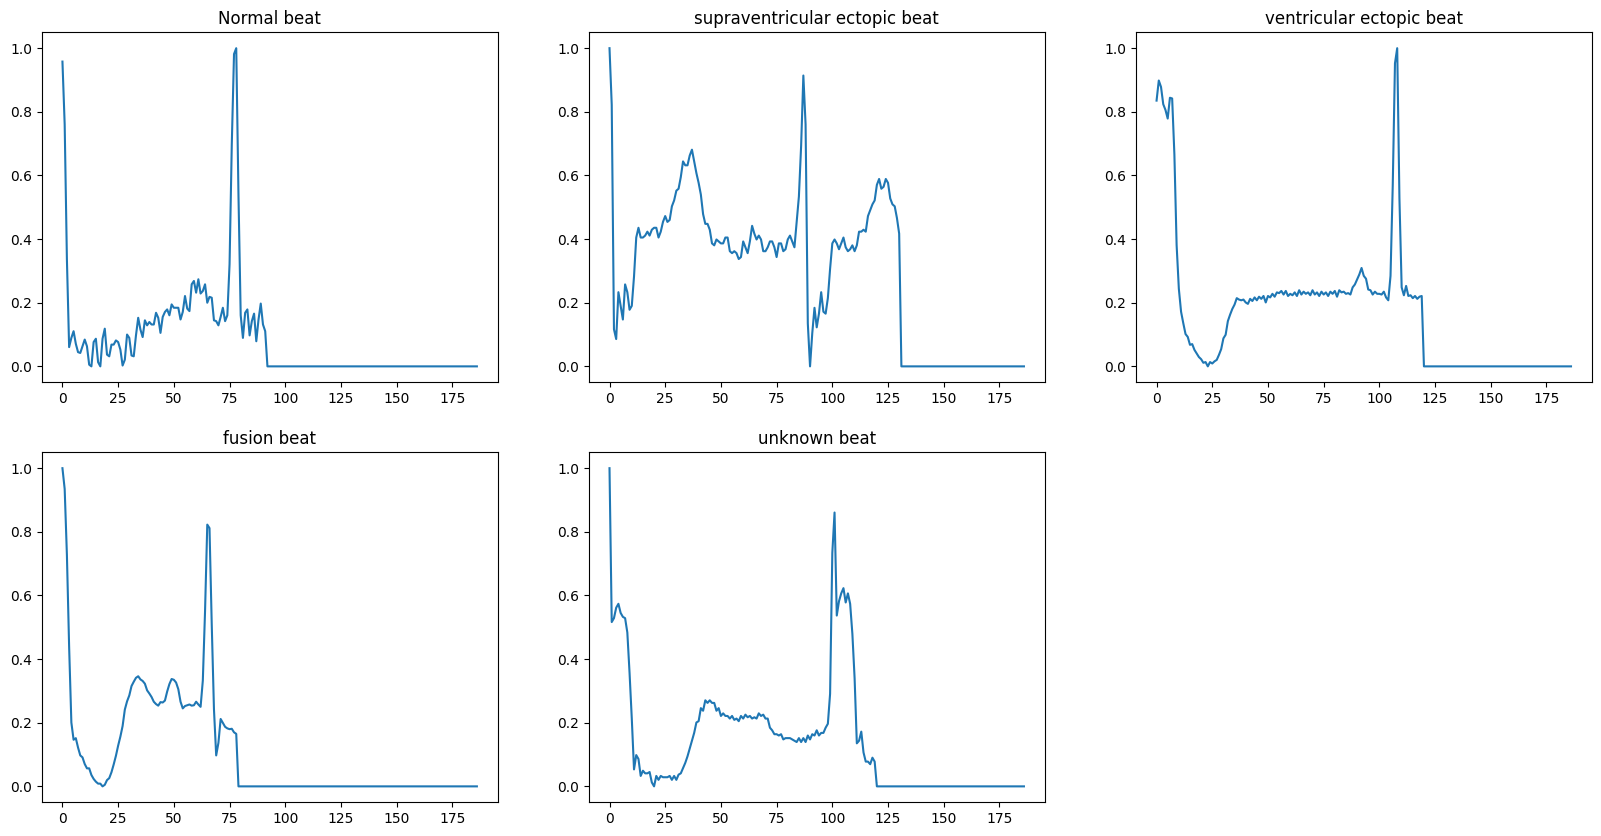

In [3]:
plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.plot (range (0,187), (train_df.loc [train_df['Label'] ==0]).sample(1).iloc [:,:-1].values[0] )
plt.title ('Normal beat')

plt.subplot(2,3,2)
plt.plot ( (train_df.loc [train_df['Label'] ==1]).sample(1).iloc [:,:-1].values[0])
plt.title ('supraventricular ectopic beat')

plt.subplot(2,3,3)
plt.plot ( (train_df.loc [train_df['Label'] ==2]).sample(1).iloc [:,:-1].values[0])
plt.title ('ventricular ectopic beat')

plt.subplot(2,3,4)
plt.plot ( (train_df.loc [train_df['Label'] ==3]).sample(1).iloc [:,:-1].values[0])
plt.title ('fusion beat')

plt.subplot(2,3,5)
plt.plot ( (train_df.loc [train_df['Label'] ==4]).sample(1).iloc [:,:-1].values[0])
plt.title ('unknown beat')

plt.show()

PIE CHART REPRESENTING NO. OF SAMPLES IN EVERY BEAT TYPE

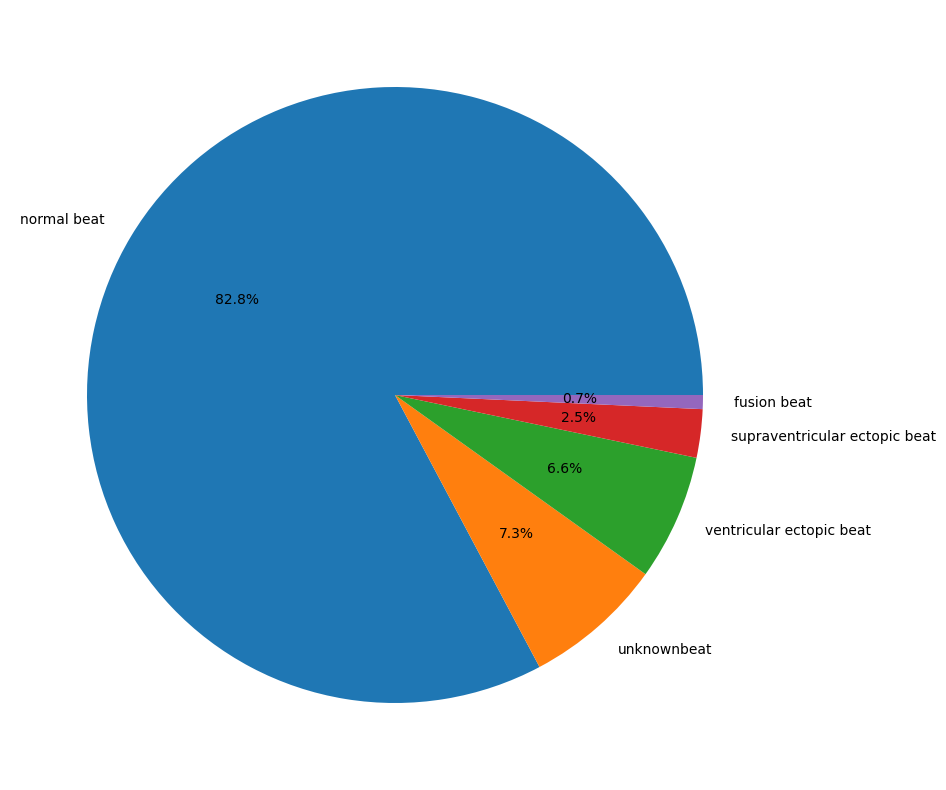

In [4]:
beats = ['normal beat' ,'unknownbeat','ventricular ectopic beat' , 'supraventricular ectopic beat' , 'fusion beat' ]
plt.figure(figsize=(20,10))
plt.pie (train_df ['Label'].value_counts().values,labels = beats,autopct='%1.1f%%')
plt.show()

OVERSAMPLING INPUT DATA

In [5]:
smote = SMOTE (sampling_strategy='all',random_state=42)
x =train_df.drop (columns ='Label')
y = train_df['Label']
x,y = smote.fit_resample (x,y)
train_df = pd.concat([x,y],axis = 1)

PIE CHART REPRESENTING NO. OF SAMPLES IN EVERY BEAT TYPE AFTER OVERSAMPLING

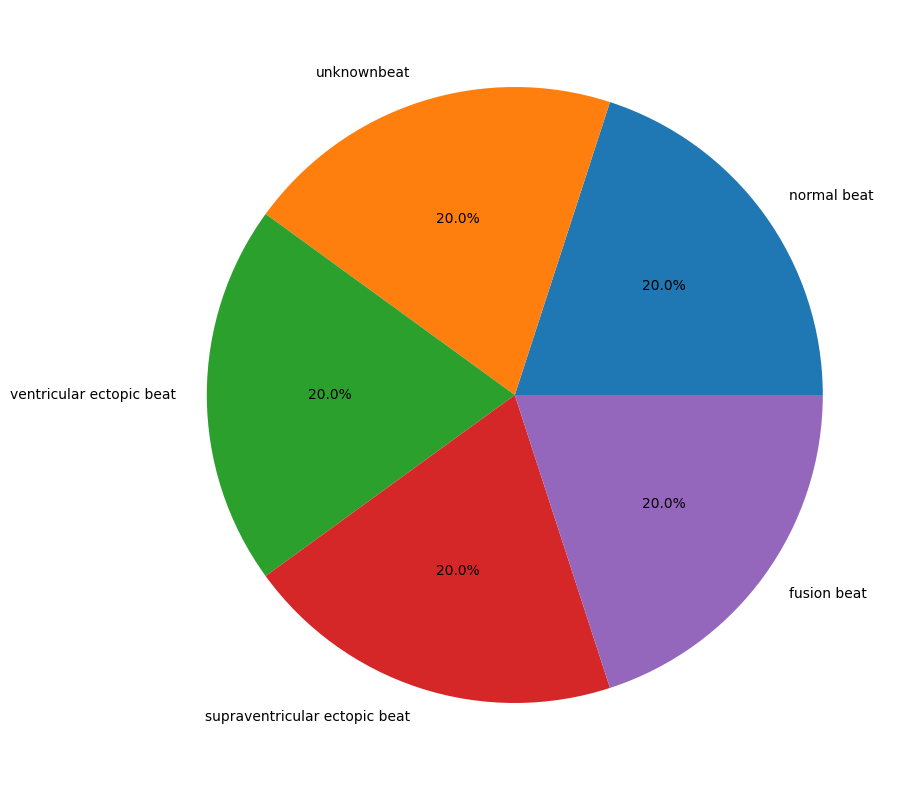

In [6]:
plt.figure(figsize=(20,10))
plt.pie (train_df ['Label'].value_counts().values,labels = beats,autopct='%1.1f%%')
plt.show()

In [7]:
train_df = train_df.sample (frac =1) 

X_train = train_df.iloc [:,:-1].values
X_train = np.expand_dims(X_train,axis = -1)
y_train = to_categorical (train_df.iloc [:,-1].values)

X_test = test_df.iloc [:,:-1].values
X_test = np.expand_dims(X_test,axis = -1)
y_test = to_categorical (test_df.iloc [:,-1].values)

In [8]:
inputs = Input (shape = (X_train.shape[1],1))
x = Conv1D(filters=64, kernel_size=7, padding="causal",activation="relu")(inputs)
x = BatchNormalization()(x)
x = MaxPool1D(3)(x)
x = Conv1D(filters=64, kernel_size=5, padding="causal",activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPool1D(3)(x)
'''x = Conv1D(filters=64, kernel_size=3, padding="causal",activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPool1D(2)(x)'''
x = keras.layers.Bidirectional( keras.layers.LSTM(64, return_sequences=True))(x)
x = keras.layers.Bidirectional( keras.layers.LSTM(32))(x)
x = Dense (16,activation = 'relu')(x)
x = Dense(5,activation = 'softmax') (x)

model = Model([inputs], outputs=x)
model.summary()
callbacks = [EarlyStopping(monitor='val_loss', patience=4, restore_best_weights = True,verbose = 1),
             ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True)]

model.compile(loss='CategoricalCrossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-4),metrics=["accuracy"])
history = model.fit (X_train, y_train,epochs=50,batch_size=32,callbacks = [callbacks],validation_data=(X_test,y_test))
model.load_weights('model.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 187, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 187, 64)           512       
                                                                 
 batch_normalization (Batch  (None, 187, 64)           256       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 62, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 62, 64)            20544     
                                                                 
 batch_normalization_1 (Bat  (None, 62, 64)            256   

MODEL'S LOSS AND ACCURACY

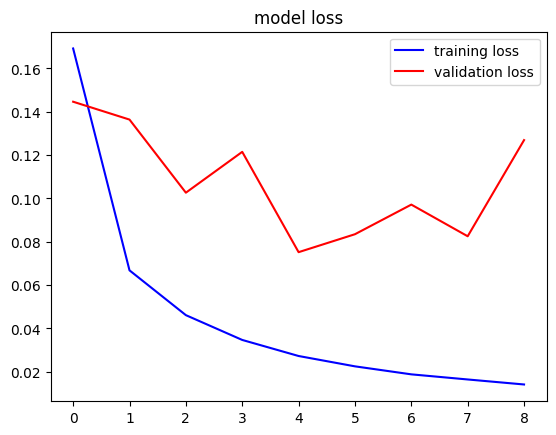

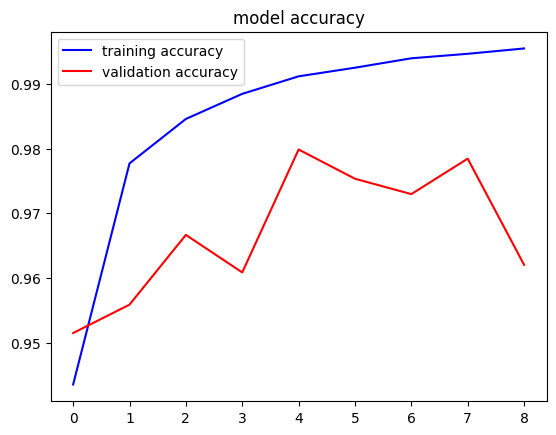

In [9]:
train_loss=history.history['loss']
val_loss = history.history['val_loss']
tarin_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range (len (train_loss)),train_loss,c='b',label = 'training loss')
plt.plot (range (len (val_loss)),val_loss,c='r',label = 'validation loss')
plt.title ('model loss')
plt.legend()
plt.show()

plt.plot(range (len (tarin_acc)),tarin_acc,c='b',label = 'training accuracy')
plt.plot (range (len (val_acc)),val_acc,c='r',label = 'validation accuracy')
plt.title ('model accuracy')
plt.legend()
plt.show()

CLASSIFICATION REPORT AND CONFUSION MATRIX

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     18118
         1.0       0.75      0.83      0.79       556
         2.0       0.97      0.94      0.95      1448
         3.0       0.75      0.80      0.77       162
         4.0       0.98      0.99      0.99      1608

    accuracy                           0.98     21892
   macro avg       0.89      0.91      0.90     21892
weighted avg       0.98      0.98      0.98     21892



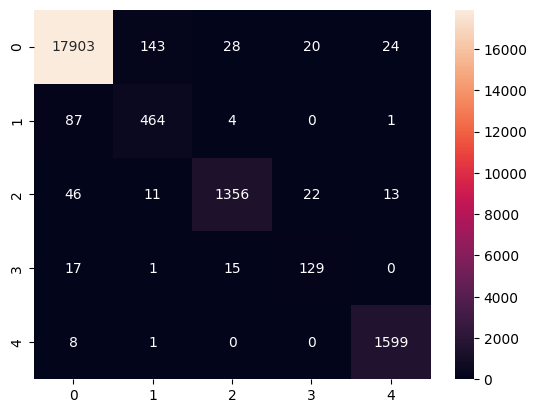

In [10]:
y_pred = np.argmax(model.predict (X_test,verbose = 0),axis =1)
y_true = test_df.iloc [:,-1].values
heatmap(confusion_matrix(y_true,y_pred),annot = True,fmt='d')
print (classification_report (y_true,y_pred))